<a href="https://colab.research.google.com/github/vinamrak/NER-using-Neural-Networks/blob/master/Main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Add all the necessary imports

This project uses the **ner_dataset**. Load it using pandas. 
The data can have NaN (null) values. These are removed by replacing them with the previous value in the same column of the dataframe using `fillna` method

In [28]:
!pip install seqeval==0.0.5
!pip install keras==2.2.4
!git clone https://www.github.com/keras-team/keras-contrib.git
!cd keras-contrib
!pip install tensorflow==1.14.0

  Found existing installation: seqeval 1.2.2
    Uninstalling seqeval-1.2.2:
      Successfully uninstalled seqeval-1.2.2


     |████████████████████████████████| 317kB 6.8MB/s 
     |████████████████████████████████| 51kB 4.4MB/s 
  Found existing installation: Keras 2.4.3
    Uninstalling Keras-2.4.3:
      Successfully uninstalled Keras-2.4.3


Cloning into 'keras-contrib'...
remote: Enumerating objects: 3634, done.
remote: Total 3634 (delta 0), reused 0 (delta 0), pack-reused 3634
Receiving objects: 100% (3634/3634), 861.24 KiB | 7.36 MiB/s, done.
Resolving deltas: 100% (2330/2330), done.
     |████████████████████████████████| 109.3MB 89kB/s 
     |████████████████████████████████| 3.2MB 33.5MB/s 
     |████████████████████████████████| 491kB 34.2MB/s 
  Found existing installation: tensorboard 2.4.1
    Uninstalling tensorboard-2.4.1:
      Successfully uninstalled tensorboard-2.4.1
  Found existing installation: tensorflow-estimator 2.4.0
    Uninstalling tensorflow-estimator-2.4.0:
      Successfully uninstalled tensorflow-estimator-2.4.0
  Found existing installation: tensorflow 2.4.1
    Uninstalling tensorflow-2.4.1:
      Successfully uninstalled tensorflow-2.4.1


python3: can't open file 'setup.py': [Errno 2] No such file or directory


In [1]:
import pandas as pd
import numpy as np

from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
from keras_contrib.layers import CRF

from keras_contrib.utils import save_load_utils

from seqeval.metrics import precision_score, recall_score, f1_score, classification_report
from sklearn.model_selection import train_test_split

Using TensorFlow backend.
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarn

In [2]:
data = pd.read_csv("ner_dataset.csv", encoding="latin1")
data = data.fillna(method="ffill")

In [3]:
data.tail(10)

,Sentence #,Word,POS,Tag
1048565,Sentence: 47958,impact,NN,O
1048566,Sentence: 47958,.,.,O
1048567,Sentence: 47959,Indian,JJ,B-gpe
1048568,Sentence: 47959,forces,NNS,O
1048569,Sentence: 47959,said,VBD,O
1048570,Sentence: 47959,they,PRP,O
1048571,Sentence: 47959,responded,VBD,O
1048572,Sentence: 47959,to,TO,O
1048573,Sentence: 47959,the,DT,O
1048574,Sentence: 47959,attack,NN,O


Find the total no: of words and tags in the dataset

In [4]:
words = list(set(data["Word"].values))
words.append("ENDPAD")
n_words = len(words); n_words

35179

In [5]:
tags = list(set(data["Tag"].values))
n_tags = len(tags); n_tags

17

The data set is of the form:<br>
Sentence X -> Word 1 -> POS1 -> Tag1<br>
Sentence X -> Word 2 -> POS2 -> Tag2<br>
Sentence X -> Word 3 -> POS3 -> Tag3<br>
.<br>
.<br>
Sentence X+1 -> Word 1 -> POS1 -> Tag1

This is converted to:<br>
Sentence X -> [(Word1, POS1, Tag1), (Word2, POS2, Tag2), (Word3, POS3, Tag3) . . . . ]]<br>
Sentence X+1 -> [(Word1, POS1, Tag1), (Word2, POS2, Tag2), (Word3, POS3, Tag3) . . . . ]]<br>
.<br>
.<br>

In [6]:
class SentenceGetter(object):
    
    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, p, t) for w, p, t in zip(s["Word"].values.tolist(),
                                                           s["POS"].values.tolist(),
                                                           s["Tag"].values.tolist())]
        self.grouped = self.data.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]
    
    #This gets the next grouped sentence i.e allows you to get sentences one by one
    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None

In [7]:
getter = SentenceGetter(data)

In [8]:
sent = getter.get_next()
print(sent)

[('Thousands', 'NNS', 'O'), ('of', 'IN', 'O'), ('demonstrators', 'NNS', 'O'), ('have', 'VBP', 'O'), ('marched', 'VBN', 'O'), ('through', 'IN', 'O'), ('London', 'NNP', 'B-geo'), ('to', 'TO', 'O'), ('protest', 'VB', 'O'), ('the', 'DT', 'O'), ('war', 'NN', 'O'), ('in', 'IN', 'O'), ('Iraq', 'NNP', 'B-geo'), ('and', 'CC', 'O'), ('demand', 'VB', 'O'), ('the', 'DT', 'O'), ('withdrawal', 'NN', 'O'), ('of', 'IN', 'O'), ('British', 'JJ', 'B-gpe'), ('troops', 'NNS', 'O'), ('from', 'IN', 'O'), ('that', 'DT', 'O'), ('country', 'NN', 'O'), ('.', '.', 'O')]


In [9]:
sentences = getter.sentences

Assign numerical label to individual words and tags. This is creating a dictionary of words to their corresponding position (index + 1) in the list.

In [10]:
max_len = 75
word2idx = {w: i + 1 for i, w in enumerate(words)}
tag2idx = {t: i for i, t in enumerate(tags)}

In [11]:
word2idx["Obama"]


9465

In [12]:
tag2idx

{'B-art': 14,
 'B-eve': 3,
 'B-geo': 5,
 'B-gpe': 0,
 'B-nat': 9,
 'B-org': 10,
 'B-per': 7,
 'B-tim': 16,
 'I-art': 11,
 'I-eve': 13,
 'I-geo': 4,
 'I-gpe': 2,
 'I-nat': 12,
 'I-org': 6,
 'I-per': 1,
 'I-tim': 8,
 'O': 15}

In [13]:
tag2idx["B-geo"]


5

In [14]:
n_words

35179

Now we map the sentences to a sequence of numbers and then pad the sequence. Note that we increased the index of the words by one to use zero as a padding value. This is done because we want to use the `mask_zero` parameter of the embedding layer to ignore inputs with value zero.

In [15]:
X = [[word2idx[w[0]] for w in s] for s in sentences]

In [16]:
X = pad_sequences(maxlen=max_len, sequences=X, padding="post", value=0)

In [17]:
y = [[tag2idx[w[2]] for w in s] for s in sentences]

In [18]:
y = pad_sequences(maxlen=max_len, sequences=y, padding="post", value=tag2idx["O"])

Perform one-hot encoding on the labels to convert the numerical value into vectors. `to_categorical` from the *Keras* library is used for this purpose. For eg, val=1 is represented as [1 0 0 0 .... 0] (number of places = total number of classes) and val = 2 as [0 1 0 0 0 ... 0] and so on



In [19]:
y = [to_categorical(i, num_classes=n_tags) for i in y]

Split the dataset into train and test random subset with a test_size of 10%. This is done with the `train_test_split` function in the *sklearn* library

In [20]:
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.1)

A Tensorflow model is built with Bidiectional LSTM and CRF layers:<br>
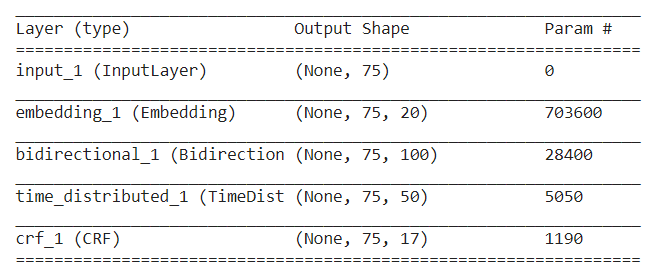 <br>

The model uses Bidirectional LSTM with CRF(Conditional Random Fields) to understand and pedict the tag of a given word based on its context. <br>
Bidirectional LSTM: A Bidirectional LSTM, or biLSTM, is a sequence processing model that consists of two LSTMs: one taking the input in a forward direction, and the other in a backwards direction. BiLSTMs effectively increase the amount of information available to the network, improving the context available to the algorithm (e.g. knowing what words immediately follow and precede a word in a sentence).
<br><br>
Optimizer: It decides how to minimize the loss calculated by the Lososs Function by adjusting the weights and biases of the model Here, **RmsProp** optimizer is being used<br>

Loss Function: It calculates the difference between the xpected and actual result in each epoch. Here **CRF Loss** function is used<br>

Metric: This is used to display the history of the raining process. It tells how the model improves or impairs.




In [21]:
input = Input(shape=(max_len,))
model = Embedding(input_dim=n_words + 1, output_dim=20,
                  input_length=max_len, mask_zero=True)(input)  # 20-dim embedding
model = Bidirectional(LSTM(units=50, return_sequences=True,
                           recurrent_dropout=0.1))(model)  # variational biLSTM
model = TimeDistributed(Dense(50, activation="relu"))(model)  # a dense layer as suggested by neuralNer
crf = CRF(n_tags)  # CRF layer
out = crf(model)  # output
model = Model(input, out)
model.compile(optimizer="rmsprop", loss=crf.loss_function, metrics=[crf.accuracy])
model.summary()





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 75)                0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 75, 20)            703600    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 75, 100)           28400     
_________________________________________________________________
time_distributed_1 (TimeDist (None, 75, 50)            5050      
_________________________________________________________________
crf_1 (CRF)                  (None, 75, 17)            1190      
Total params: 738,240
Trainable params: 738,240
Non-trainable params: 0
_________________________________________________________________


The model is fit(trained) on the training dataset we made earlier. 

In [22]:
history = model.fit(X_tr, np.array(y_tr), batch_size=32, epochs=5, validation_split=0.1, verbose=1)


Train on 38846 samples, validate on 4317 samples
Epoch 1/5
38846/38846 [==============================] - 201s 5ms/step - loss: 8.9344 - crf_viterbi_accuracy: 0.9051 - val_loss: 8.8136 - val_crf_viterbi_accuracy: 0.9478
Epoch 2/5
38846/38846 [==============================] - 201s 5ms/step - loss: 8.7139 - crf_viterbi_accuracy: 0.9582 - val_loss: 8.7675 - val_crf_viterbi_accuracy: 0.9590
Epoch 3/5
38846/38846 [==============================] - 209s 5ms/step - loss: 8.6840 - crf_viterbi_accuracy: 0.9663 - val_loss: 8.7514 - val_crf_viterbi_accuracy: 0.9639
Epoch 4/5
38846/38846 [==============================] - 216s 6ms/step - loss: 8.6721 - crf_viterbi_accuracy: 0.9700 - val_loss: 8.7465 - val_crf_viterbi_accuracy: 0.9651
Epoch 5/5
38846/38846 [==============================] - 216s 6ms/step - loss: 8.6657 - crf_viterbi_accuracy: 0.9722 - val_loss: 8.7432 - val_crf_viterbi_accuracy: 0.9650


Use the trained model to predict the tags of sentences in the test dataset

In [23]:
test_pred = model.predict(X_te, verbose=1)

4796/4796 [==============================] - 8s 2ms/step


Try out the model on a single sentence fom the test dataset. The output from the model are the numerical labels that we converted the input into before. So as these labels are the indices of the actual list of words and tags, it is used to display the words and their corresponding tags by getting the right element from the lists

In [26]:
#print(classification_report(test_labels, pred_labels))
i = 1928
p = model.predict(np.array([X_te[i]]))
p = np.argmax(p, axis=-1)
true = np.argmax(y_te[i], -1)
print("{:15}||{:5}||{}".format("Word", "True", "Pred")) # Create a table form with the pipe symbol (|)
print(30 * "=")
for w, t, pred in zip(X_te[i], true, p[0]):
    if w != 0:
        print("{:15}: {:5} {}".format(words[w-1], tags[t], tags[pred]))

Word           ||True ||Pred
It             : O     O
was            : O     O
approved       : O     O
after          : O     O
the            : O     O
European       : B-org B-org
Union          : I-org I-org
withdrew       : O     O
a              : O     O
more           : O     O
strongly       : O     O
worded         : O     O
document       : O     O
that           : O     O
would          : O     O
have           : O     O
condemned      : O     O
the            : O     O
Sudanese       : B-gpe B-gpe
government     : O     O
for            : O     O
its            : O     O
role           : O     O
in             : O     O
the            : O     O
violence       : O     O
.              : O     O


Create a function to readily do NER on a random sentence

In [34]:
import re
def predict(sent):
  test_sentence = re.sub("[^\w]", " ", sent).split()
  x_test_sent = pad_sequences(sequences=[[word2idx.get(w, 0) for w in test_sentence]], padding="post", value=0, maxlen=max_len)

  p = model.predict(np.array([x_test_sent[0]]))
  p = np.argmax(p, axis=-1)
  print("{:15}||{}".format("Word", "Prediction"))
  print(30 * "=")
  for w, pred in zip(test_sentence, p[0]):
      print("{:15}: {:5}".format(w, tags[pred]))

In [35]:
sentence= """Hawking was a Fellow of the Royal Society, a lifetime member of the 
Pontifical Academy of Sciences, and a recipient of the Presidential Medal of Freedom, 
the highest civilian award in the United States. """
predict(sentence)

Word           ||Prediction
Hawking        : B-gpe
was            : O    
a              : O    
Fellow         : O    
of             : O    
the            : O    
Royal          : B-org
Society        : I-org
a              : O    
lifetime       : O    
member         : O    
of             : O    
the            : O    
Pontifical     : B-org
Academy        : I-org
of             : I-org
Sciences       : I-org
and            : O    
a              : O    
recipient      : O    
of             : O    
the            : O    
Presidential   : O    
Medal          : B-gpe
of             : O    
Freedom        : B-org
the            : O    
highest        : O    
civilian       : O    
award          : O    
in             : O    
the            : O    
United         : B-geo
States         : I-geo


Save the model in *.h5* format so that it'll be available for later use

In [ ]:
filename = "model1"
save_load_utils.save_all_weights(model,filename)

In [ ]:
save_load_utils.load_all_weights(model,"model1")